<a href="https://colab.research.google.com/github/manvgom/Pickioset/blob/main/MMClass_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!mkdir -p dataset
!unzip -qo drive/MyDrive/MTDI_TFM/PICKIOSET/openMMlab_ds.zip -d ./dataset/

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Mounted at /content/drive


In [2]:
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

1.11.0+cu113
False


In [3]:
# Install mmcv
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 537 kB 5.4 MB/s 
     |████████████████████████████████| 190 kB 44.6 MB/s 
  Created wheel for mmcv: filename=mmcv-1.5.1-py2.py3-none-any.whl size=817971 sha256=703340addc519dae19d30ee934f619462d2fa974b31d7ec4d982a224efeb19e6
  Stored in directory: /root/.cache/pip/wheels/7e/13/34/79ae316926b309574ce9b81376dd860dea766bcaa7c68d85fb
Successfully built mmcv


In [4]:
# Clone mmcls repository
!git clone https://github.com/open-mmlab/mmclassification.git
%cd mmclassification/

# Install MMClassification from source
!pip install -e . 

Cloning into 'mmclassification'...
remote: Enumerating objects: 6623, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6623 (delta 0), reused 1 (delta 0), pack-reused 6618
Receiving objects: 100% (6623/6623), 9.37 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (4410/4410), done.
/content/mmclassification
Obtaining file:///content/mmclassification
  Running setup.py develop for mmcls


In [5]:
# Check MMClassification installation
import mmcls
print(mmcls.__version__)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
0.23.0


In [7]:
# Confirm the config file exists
#!ls configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py

# Specify the path of the config file and checkpoint file.
config_file = 'https://github.com/open-mmlab/mmclassification/blob/master/configs/efficientnet/efficientnet-b0_8xb32_in1k.py'
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/efficientnet/efficientnet-b0_3rdparty_8xb32_in1k_20220119-a7e2a0b1.pth'

In [8]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

# Specify the device, if you cannot use GPU, you can also use CPU 
# by specifying `device='cpu'`.
#device = 'cuda:0'
device = 'cpu'

# Build the model according to the config file and load the checkpoint.
model = init_model(config_file, checkpoint_file, device=device)

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


FileNotFoundError: ignored

In [ ]:
# The model's inheritance relationship
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [ ]:
# Load the base config file
from mmcv import Config
cfg = Config.fromfile('https://github.com/open-mmlab/mmclassification/blob/master/configs/efficientnet/efficientnet-b0_8xb32_in1k.py)

# Modify the number of classes in the head.
cfg.model.head.num_classes = 18
cfg.model.head.topk = (1, )

# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 2

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = '/content/dataset/openMMlab_ds/training_set/training_set'
cfg.data.train.classes = '/content/dataset/openMMlab_ds/classes.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = '/content/dataset/openMMlab_ds/val_set/val_set'
cfg.data.val.ann_file = '/content/dataset/openMMlab_ds/val.txt'
cfg.data.val.classes = '/content/dataset/openMMlab_ds/classes.txt'

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = '/content/dataset/openMMlab_ds/test_set/test_set'
cfg.data.test.ann_file = '/content/dataset/openMMlab_ds/test.txt'
cfg.data.test.classes = '/content/dataset/openMMlab_ds/classes.txt'

# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=2)

# Specify the work directory
cfg.work_dir = './work_dirs/openMMlab_ds'

# Output logs for every 10 iterations
cfg.log_config.interval = 10

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

In [ ]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create the work directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
model.init_weights()
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add `CLASSES` attributes to help visualization
model.CLASSES = datasets[0].CLASSES
# Start fine-tuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2022-05-08 02:29:12,174 - mmcv - INFO - initialize MobileNetV2 with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth', 'prefix': 'backbone'}
2022-05-08 02:29:12,176 - mmcv - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
2022-05-08 02:29:12,229 - mmcv - INFO - initialize LinearClsHead with init_cfg {'type': 'Normal', 'layer': 'Linear', 'std': 0.01}
2022-05-08 02:29:12,232 - mmcv - INFO - 
backbone.conv1.conv.weight - torch.Size([32, 3, 3, 3]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-05-08 02:29:12,235 - mmcv - INFO - 
backbone.conv1.bn.weight - torch.Size([32]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilen

load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


2022-05-08 02:29:12,382 - mmcv - INFO - 
backbone.layer4.3.conv.2.bn.bias - torch.Size([64]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-05-08 02:29:12,383 - mmcv - INFO - 
backbone.layer5.0.conv.0.conv.weight - torch.Size([384, 64, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-05-08 02:29:12,385 - mmcv - INFO - 
backbone.layer5.0.conv.0.bn.weight - torch.Size([384]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-05-08 02:29:12,386 - mmcv - INFO - 
backbone.layer5.0.conv.0.bn.bias - torch.Size([384]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth 
 
2022-05-08 02:29:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 278/278, 17.5 task/s, elapsed: 16s, ETA:     0s

2022-05-08 02:33:07,148 - mmcls - INFO - Epoch(val) [1][9]	accuracy_top-1: 99.6403
2022-05-08 02:34:08,007 - mmcls - INFO - Epoch [2][10/35]	lr: 5.000e-04, eta: 0:02:19, time: 6.085, data_time: 0.274, loss: 0.2986
2022-05-08 02:35:03,177 - mmcls - INFO - Epoch [2][20/35]	lr: 5.000e-04, eta: 0:01:23, time: 5.517, data_time: 0.008, loss: 0.2370
2022-05-08 02:35:59,484 - mmcls - INFO - Epoch [2][30/35]	lr: 5.000e-04, eta: 0:00:27, time: 5.631, data_time: 0.009, loss: 0.2227
2022-05-08 02:36:26,166 - mmcls - INFO - Saving checkpoint at 2 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 278/278, 19.1 task/s, elapsed: 15s, ETA:     0s

2022-05-08 02:36:40,834 - mmcls - INFO - Epoch(val) [2][9]	accuracy_top-1: 100.0000


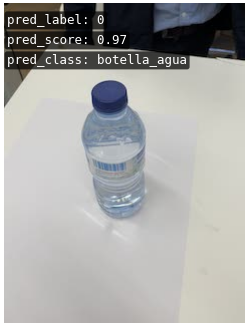

In [ ]:
%matplotlib inline
# Validate the fine-tuned model
img = mmcv.imread('/content/dataset/openMMlab_ds/training_set/training_set/botella_agua/35.jpg')
model.cfg = cfg
result = inference_model(model, img)
show_result_pyplot(model, img, result)